<a href="https://colab.research.google.com/github/GrE3lzzz/Gittea/blob/main/Atari_Games.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gym[atari]==0.26.2 torch
!pip install autorom
!AutoROM --accept-license
!pip install numpy==1.23.5 --upgrade --force-reinstall
!pip install --upgrade "jax[cpu]"
!pip install --upgrade tensorflow

AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.11/dist-packages/AutoROM/roms

Existing ROMs will be overwritten.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 60.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
blosc2 3.2.0 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
bigframes 1.38.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 68.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.2.3 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.3 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.19.0 which is incompatible.
pytensor 2.27.1 requires numpy<2,>=1.17.0, but you have numpy 2.2.3 which is incompatible.
thinc 8.2.5 requires numpy<2.0.0,>=1.19.0; python_version >= "3.9", but you have numpy 2.2.3 which is incompatible.
tensorflow-text 2.18

In [ ]:
!pip install numpy==1.25.0 --upgrade --force-reinstall

  Using cached numpy-1.25.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached numpy-1.25.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 1.25.0 which is incompatible.
blosc2 3.2.0 requires numpy>=1.26, but you have numpy 1.25.0 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.19.0 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.25.0 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.19.0 which is incom

In [ ]:
import argparse
import random
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
from gym.wrappers import AtariPreprocessing, FrameStack, TransformObservation
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

In [ ]:
# Hyperparameters
BATCH_SIZE = 32
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 10000
TARGET_UPDATE = 1000
MEMORY_SIZE = 100000
LEARNING_RATE = 0.0001
EPISODES = 15

In [ ]:
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        if len(input_shape) == 1:  # CartPole
            self.fc = nn.Sequential(
                nn.Linear(input_shape[0], 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, n_actions)
            )
        else:  # Atari games
            self.conv = nn.Sequential(
                nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
                nn.ReLU(),
                nn.Conv2d(32, 64, kernel_size=4, stride=2),
                nn.ReLU(),
                nn.Conv2d(64, 64, kernel_size=3, stride=1),
                nn.ReLU()
            )
            conv_out_size = self._get_conv_out(input_shape)
            self.fc = nn.Sequential(
                nn.Linear(conv_out_size, 512),
                nn.ReLU(),
                nn.Linear(512, n_actions)
            )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        if len(x.shape) == 2:  # CartPole
            return self.fc(x)
        else:  # Atari
            x = self.conv(x)
            x = x.view(x.size(0), -1)
            return self.fc(x)

In [ ]:
class ReplayMemory:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

In [ ]:
class DQNAgent:
    def __init__(self, env_name, use_atari=False):
        self.env_name = env_name
        self.use_atari = use_atari

        if use_atari:
            self.env = gym.make(f"ALE/{env_name}-v5", render_mode='rgb_array', frameskip=1)
            self.env = AtariPreprocessing(self.env,
                                          grayscale_obs=True,
                                          scale_obs=True,
                                          frame_skip=4)
            self.env = FrameStack(self.env, 4)
            self.env = TransformObservation(self.env, lambda obs: np.array(obs))
        else:
            self.env = gym.make(env_name)

        self.state, _ = self.env.reset()
        self.n_actions = self.env.action_space.n
        self.input_shape = (4, 84, 84) if use_atari else self.state.shape

        self.policy_net = DQN(self.input_shape, self.n_actions).to('cpu')
        self.target_net = DQN(self.input_shape, self.n_actions).to('cpu')
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=LEARNING_RATE)
        self.memory = ReplayMemory(MEMORY_SIZE)

        self.steps_done = 0
        self.writer = SummaryWriter(f'runs/{env_name}')

    def select_action(self, state, epsilon):
        sample = random.random()
        if sample > epsilon:
            with torch.no_grad():
                return self.policy_net(state.to('cpu')).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[self.env.action_space.sample()]], device='cpu', dtype=torch.long)

    def preprocess_state(self, state):
        if not self.use_atari:
            return torch.tensor(state, dtype=torch.float32).unsqueeze(0).to('cpu')
        else:
            state_tensor = torch.from_numpy(state).float().to('cpu')
            return state_tensor.unsqueeze(0)

    def train_step(self):
        if len(self.memory) < BATCH_SIZE:
            return

        transitions = self.memory.sample(BATCH_SIZE)
        batch = list(zip(*transitions))

        state_batch = torch.cat([s for s in batch[0]]).to('cpu')
        action_batch = torch.cat(batch[1]).to('cpu')
        reward_batch = torch.cat(batch[2]).to('cpu')
        next_state_batch = torch.cat([s for s in batch[3] if s is not None]).to('cpu')
        done_batch = torch.tensor(batch[4], device='cpu')

        current_q_values = self.policy_net(state_batch).gather(1, action_batch)
        next_q_values = torch.zeros(BATCH_SIZE, device='cpu')
        with torch.no_grad():
            non_terminal_mask = ~done_batch
            non_terminal_next_states = next_state_batch[non_terminal_mask]
            if non_terminal_next_states.shape[0] > 0:
                next_q_values[non_terminal_mask] = self.target_net(non_terminal_next_states).max(1)[0].detach()
        expected_q_values = (next_q_values * GAMMA) + reward_batch

        loss = nn.MSELoss()(current_q_values.squeeze(), expected_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def train(self):
        rewards_history = []  # List to store rewards for plotting

        for episode in range(EPISODES):
            state, _ = self.env.reset()
            state = self.preprocess_state(state)
            total_reward = 0
            losses = []

            epsilon = np.interp(self.steps_done, [0, EPS_DECAY], [EPS_START, EPS_END])
            epsilon = max(epsilon, EPS_END)

            while True:
                action = self.select_action(state, epsilon)
                next_state, reward, done, truncated, _ = self.env.step(action.item())
                next_state = self.preprocess_state(next_state)

                total_reward += reward
                reward = torch.tensor([reward], device='cpu')
                self.memory.push(state, action, reward, next_state, done or truncated)

                state = next_state
                self.steps_done += 1

                loss = self.train_step()
                if loss:
                    losses.append(loss)

                if self.steps_done % TARGET_UPDATE == 0:
                    self.target_net.load_state_dict(self.policy_net.state_dict())

                if done or truncated:
                    break

            rewards_history.append(total_reward)  # Save total reward for this episode
            self.writer.add_scalar('Reward', total_reward, episode)
            self.writer.add_scalar('Epsilon', epsilon, episode)
            if losses:
                self.writer.add_scalar('Loss', np.mean(losses), episode)

            print(f"Game: {self.env_name}, Episode: {episode}, Reward: {total_reward}, Epsilon: {epsilon:.2f}")

            if episode % 10 == 0:
                torch.save(self.policy_net.state_dict(), f'{self.env_name}_dqn.pth')

        # Save rewards history to a file
        with open(f'{self.env_name}_rewards.txt', 'w') as f:
            for reward in rewards_history:
                f.write(f"{reward}\n")


def moving_average(data, window_size):
    """
    Compute the moving average of a list of data.

    Args:
        data (list): List of numerical values.
        window_size (int): Size of the moving average window.

    Returns:
        list: Smoothed data using a moving average.
    """
    return np.convolve(data, np.ones(window_size), 'valid') / window_size


def plot_rewards(env_name, window_size=10):
    # Load rewards from the file
    rewards = []
    with open(f'{env_name}_rewards.txt', 'r') as f:
        for line in f:
            rewards.append(float(line.strip()))

    # Apply moving average to smooth the rewards
    smoothed_rewards = moving_average(rewards, window_size)

    # Plot the original and smoothed rewards
    plt.figure(figsize=(10, 6))
    plt.plot(rewards, label=f'{env_name} Raw Rewards', color='lightblue', alpha=0.5)
    plt.plot(range(window_size - 1, len(rewards)), smoothed_rewards, label=f'{env_name} Smoothed Rewards', color='blue')
    plt.title(f'Rewards Over Episodes for {env_name}')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    plt.legend()
    plt.savefig(f'{env_name}_smoothed_rewards_plot.png')  # Save the plot as an image
    plt.show()

Training agent for CartPole-v1...
Game: CartPole-v1, Episode: 0, Reward: 24.0, Epsilon: 1.00
Game: CartPole-v1, Episode: 1, Reward: 10.0, Epsilon: 1.00
Game: CartPole-v1, Episode: 2, Reward: 11.0, Epsilon: 1.00
Game: CartPole-v1, Episode: 3, Reward: 17.0, Epsilon: 1.00
Game: CartPole-v1, Episode: 4, Reward: 12.0, Epsilon: 0.99
Game: CartPole-v1, Episode: 5, Reward: 13.0, Epsilon: 0.99
Game: CartPole-v1, Episode: 6, Reward: 22.0, Epsilon: 0.99
Game: CartPole-v1, Episode: 7, Reward: 16.0, Epsilon: 0.99
Game: CartPole-v1, Episode: 8, Reward: 14.0, Epsilon: 0.99
Game: CartPole-v1, Episode: 9, Reward: 27.0, Epsilon: 0.99
Game: CartPole-v1, Episode: 10, Reward: 19.0, Epsilon: 0.98
Game: CartPole-v1, Episode: 11, Reward: 18.0, Epsilon: 0.98
Game: CartPole-v1, Episode: 12, Reward: 14.0, Epsilon: 0.98
Game: CartPole-v1, Episode: 13, Reward: 46.0, Epsilon: 0.98
Game: CartPole-v1, Episode: 14, Reward: 27.0, Epsilon: 0.97
Training agent for SpaceInvaders...
Game: SpaceInvaders, Episode: 0, Reward:

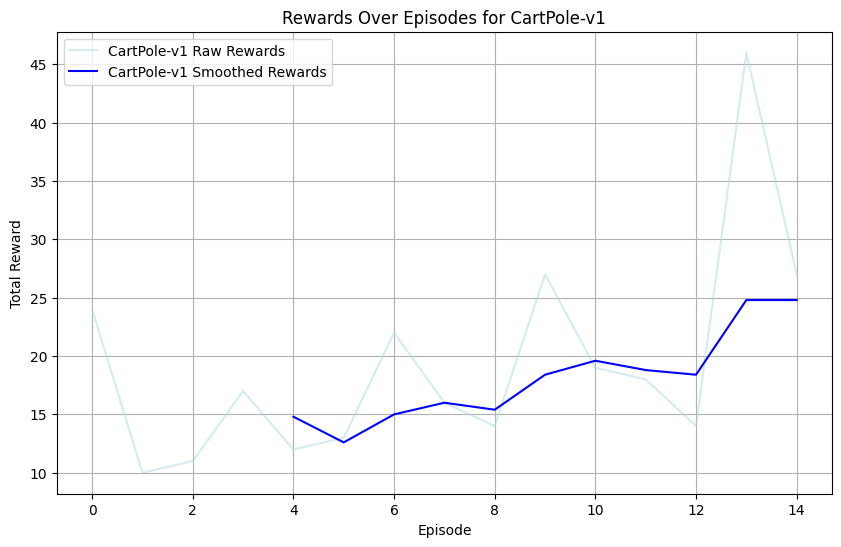

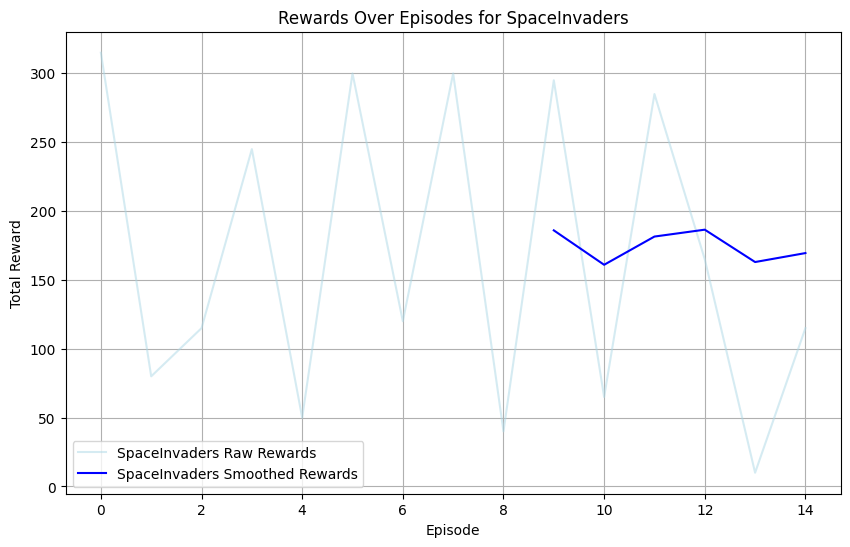

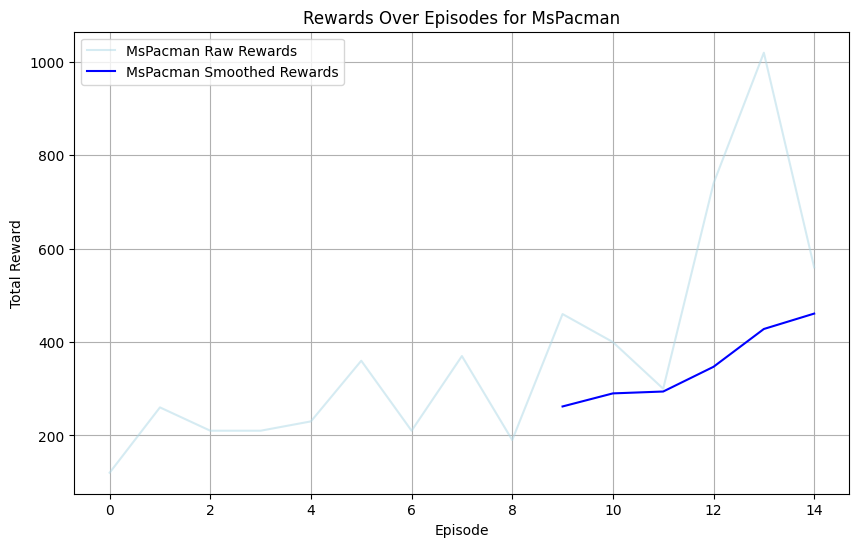

In [ ]:
if __name__ == "__main__":
    # List of games to train on
    games = [
        {"name": "CartPole-v1", "use_atari": False},
        {"name": "SpaceInvaders", "use_atari": True},
        {"name": "MsPacman", "use_atari": True}
    ]

    # Train an agent for each game
    for game in games:
        print(f"Training agent for {game['name']}...")
        agent = DQNAgent(game["name"], use_atari=game["use_atari"])
        agent.train()

    # Plot rewards for each game
    for game in games:
        plot_rewards(game["name"], window_size=10 if game["use_atari"] else 5)